In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/raw/bank-dataset.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261.0,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151.0,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76.0,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92.0,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,unknown,5,may,198.0,1,-1,0,unknown,no


In [3]:
len(df)

43097

<html>
<h1 style="text-align:left;color:red;font-size:200%">Table of Contents : </h1>
</html>

  1. [Preprocessing](#sec1)
  2. [Manage Missing](#sec2)
  3. [Encoding](#sec3)
  4. [Split dataset](#sec4)
  5. [Feature Scaling](#sec5)
  6. [Feature Selection](#sec6)
  7. [Undersampling](#sec7)

## 1. Preprocessing <a class="anchor" id="sec1"></a>

* Eliminare persone che hanno 150 anni e hanno un lavoro diverso da 'retired' o 'unknown'
* creare una variabile categorica pdays pari a 1 se il cliente è stato contattato in precedenza, 0 altrimenti (se pdays=-1)
* creare una variabile categorica basata sui valori numerici di previous
* correggere marital
* gestire i missing

In [4]:
# Eliminare persone che hanno 150 anni e hanno un lavoro diverso da 'retired' o 'unknown'

drop_idx = df[(df['age']==150)&(df['job'].isin(['management', 'technician', 'entrepreneur', 'blue-collar',
        'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student']))].index.to_list()
print(len(drop_idx))
df = df[~(df.index.isin(drop_idx))]
print(df[df.age>100].job.unique())
print(len(df))

122
['retired' 'unknown']
42975


In [5]:
# creare una variabile categorica pdays pari a 1 se il cliente è stato contattato in precedenza, 0 altrimenti (se pdays=-1)
df['pdays_cat'] = df['pdays'].apply(lambda x: 1 if x!=-1 else 0)
df['pdays_cat'].value_counts()
# valorizzare pdays pari a 0 quando ha -1
df.pdays[df.pdays<0]=0

In [6]:
df.previous.value_counts()[:5]

previous
0    35507
1     2528
2     1910
3     1030
4      644
Name: count, dtype: int64

In [7]:
df[df.previous>0].previous.describe()

count    7468.000000
mean        3.166577
std         4.657821
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

In [8]:
# creare una variabile categorica basata sui valori numerici di previous
df.rename(columns={'previous':'previous_num'},inplace=True)
previous_q75 = df.previous_num[df.previous_num>0].quantile(0.75) #4
previous_max =df.previous_num[df.previous_num>0].max() #275
#df['previous'] = pd.cut(df['previous_num'],bins=[-0.001,0,previous_q75,previous_max+1])
df['previous'] = pd.cut(df['previous_num'],bins=[-0.001,0,previous_q75+1,previous_max+1],labels=[0,1,2])
df.drop(['previous_num'],axis=1,inplace=True)
df['previous'].value_counts()

previous
0    35507
1     6534
2      934
Name: count, dtype: int64

In [9]:
#correggere marital
diz_marital = {'singl':'single','divrcd':'divorced'}
df['marital'] = df['marital'].map(lambda x: x.lower() if x.lower() not in diz_marital.keys() else diz_marital[x.lower()])
print(len(df[df.marital=='s'])/len(df)*100)
df = df[df.marital!='s']
print(len(df))

0.09075043630017451
42936


## 1. Manage Missings <a class="anchor" id="sec2"></a>

Ci sono missing nelle seguenti variabili:
* 0.05% in age --> fillata con la mediana dell'età
* 0.13% in contact --> fillato come unknown
* 0.17% in duration --> elimino duration perché influisce molto sulla variabile target. Se duration=0, y=0
* 0.023% in poutcome --> elimino poutcome perchè più dell'80% è non conosciuto

In [10]:
df.isnull().sum()/len(df)*100

age          0.053568
job          0.000000
marital      0.000000
education    0.000000
default      0.000000
balance      0.000000
housing      0.000000
loan         0.000000
contact      0.135085
day          0.000000
month        0.000000
duration     0.177008
campaign     0.000000
pdays        0.000000
poutcome     0.023290
y            0.000000
pdays_cat    0.000000
previous     0.000000
dtype: float64

In [11]:
df.age.describe()

count    42913.000000
mean        40.993126
std         10.799766
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max        150.000000
Name: age, dtype: float64

In [12]:
# valorizzare i missing di age con la mediana dell'età
df['age'].fillna(df['age'].median(),inplace=True)

In [13]:
# valorizzare i missing di contact come unknown
df.contact[df.contact.isnull()]='unknown'
print(df.contact.value_counts())
print(df.contact.isnull().sum())

contact
cellular     27500
unknown      12704
telephone     2732
Name: count, dtype: int64
0


In [14]:
# elimino duration e poutcome
df.drop(['duration','day','poutcome'],axis=1,inplace=True)

## 3. Encoding <a class="anchor" id="sec3"></a>

* job, marital, poutcome,contact are **non-ordered categorical variables** --> One-hot encoding
* default, housing,loan and y are **binary** --> Ordinal Labeling
* month, day and education are **ordered variables** --> Ordinal Labeling

In [15]:
categ_features = df.columns[df.dtypes=='object'].to_list() 
categ_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'y']

In [16]:
for c in categ_features:
    print('Unique values of {}: \n'.format(c))
    print(df[c].value_counts(normalize=True))

Unique values of job: 

job
blue-collar      0.219466
management       0.207891
technician       0.168553
admin.           0.114380
services         0.092463
retired          0.048095
self-employed    0.035192
entrepreneur     0.033305
unemployed       0.028135
housemaid        0.027739
student          0.018306
unknown          0.006475
Name: proportion, dtype: float64
Unique values of marital: 

marital
married     0.607625
single      0.276668
divorced    0.115707
Name: proportion, dtype: float64
Unique values of education: 

education
secondary    0.515395
tertiary     0.290572
primary      0.153484
unknown      0.040549
Name: proportion, dtype: float64
Unique values of default: 

default
no     0.981391
yes    0.018609
Name: proportion, dtype: float64
Unique values of housing: 

housing
yes    0.564654
no     0.435346
Name: proportion, dtype: float64
Unique values of loan: 

loan
no     0.835988
yes    0.164012
Name: proportion, dtype: float64
Unique values of contact: 

contact
c

In [17]:
diz_month = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df['month'] = df['month'].map(lambda x: diz_month[x])

In [18]:
diz_ed = {'primary':1,'secondary':2,'tertiary':3,'unknown':0}
df['education'] = df['education'].map(lambda x: diz_ed[x] if x in diz_ed.keys() else x)

In [19]:
l_binary = ['default','housing','loan','y']
for c in l_binary:
        df[c] = df[c].apply(lambda x: 1 if x=='yes' else 0)

In [20]:
for c in categ_features:
    print('Unique values of {}: \n'.format(c))
    print(df[c].value_counts(normalize=True))

Unique values of job: 

job
blue-collar      0.219466
management       0.207891
technician       0.168553
admin.           0.114380
services         0.092463
retired          0.048095
self-employed    0.035192
entrepreneur     0.033305
unemployed       0.028135
housemaid        0.027739
student          0.018306
unknown          0.006475
Name: proportion, dtype: float64
Unique values of marital: 

marital
married     0.607625
single      0.276668
divorced    0.115707
Name: proportion, dtype: float64
Unique values of education: 

education
2    0.515395
3    0.290572
1    0.153484
0    0.040549
Name: proportion, dtype: float64
Unique values of default: 

default
0    0.981391
1    0.018609
Name: proportion, dtype: float64
Unique values of housing: 

housing
1    0.564654
0    0.435346
Name: proportion, dtype: float64
Unique values of loan: 

loan
0    0.835988
1    0.164012
Name: proportion, dtype: float64
Unique values of contact: 

contact
cellular     0.640488
unknown      0.295882
t

### One-hot encoding 

In [21]:
from sklearn.preprocessing import OneHotEncoder

cols_to_encode = ['job', 'marital','contact']

# Step 1: Extract the columns to be encoded
data_to_encode = df[cols_to_encode]

# Step 2: Create an instance of the OneHotEncoder
encoder = OneHotEncoder(dtype='int')

# Step 3: Fit and transform the data using the encoder
encoded_data = encoder.fit_transform(data_to_encode)

In [22]:
dummy_variables = encoder.get_feature_names_out(cols_to_encode)
dummy_variables

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown'],
      dtype=object)

In [23]:
# Step 4: Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(cols_to_encode))

# Step 5: Concatenate the encoded DataFrame with the remaining columns from the original DataFrame
final_df = pd.concat([df.drop(cols_to_encode, axis=1), encoded_df], axis=1)

In [24]:
final_df.isnull().sum()

age                  160
education            160
default              160
balance              160
housing              160
loan                 160
month                160
campaign             160
pdays                160
y                    160
pdays_cat            160
previous             160
job_admin.           160
job_blue-collar      160
job_entrepreneur     160
job_housemaid        160
job_management       160
job_retired          160
job_self-employed    160
job_services         160
job_student          160
job_technician       160
job_unemployed       160
job_unknown          160
marital_divorced     160
marital_married      160
marital_single       160
contact_cellular     160
contact_telephone    160
contact_unknown      160
dtype: int64

In [25]:
final_df = final_df[final_df.age.notnull()]

In [26]:
final_df = final_df[final_df.job_retired.notnull()]

In [27]:
final_df.head()

,age,education,default,balance,housing,loan,month,campaign,pdays,y,...,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown
0,58.0,3.0,0.0,2143.0,1.0,0.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,44.0,2.0,0.0,29.0,1.0,0.0,5.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,33.0,2.0,0.0,2.0,1.0,1.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,47.0,0.0,0.0,1506.0,1.0,0.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,33.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## 14. Split dataset <a class="anchor" id="sec4"></a>

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X = final_df.drop(['y'],axis=1)
y = final_df['y']

In [30]:
train_idx, test_idx,y_train,_ = train_test_split(X.index,y,test_size=0.2,stratify=y,random_state=123)

In [31]:
set(train_idx).intersection(set(test_idx))

set()

In [32]:
len(train_idx),len(test_idx)

(34220, 8556)

In [33]:
train_idx, val_idx,_,_ = train_test_split(train_idx,y_train,test_size=0.2,stratify=y_train,random_state=123)

In [34]:
set(train_idx).intersection(set(val_idx))

set()

In [35]:
len(train_idx),len(val_idx)

(27376, 6844)

In [36]:
df_train = final_df[final_df.index.isin(train_idx)]
df_test = final_df[final_df.index.isin(test_idx)]
df_val = final_df[final_df.index.isin(val_idx)]

## 5. Feature Scaling <a class="anchor" id="sec5"></a>

* C'è molta variabilità nelle variabili e ci sono molti outlier con valori alti
* Quindi, restringo il range di queste variabili applicando il Robust Scaler: 
**(x-median)/(q75-q25)**

In [37]:
from sklearn.preprocessing import RobustScaler

In [38]:
numeric_features = ['age', 'balance', 'campaign', 'pdays']

In [39]:
from sklearn.preprocessing import RobustScaler

sc=RobustScaler()
df_train[numeric_features]=sc.fit_transform(df_train[numeric_features])
df_test[numeric_features]=sc.transform(df_test[numeric_features])
df_val[numeric_features]=sc.transform(df_val[numeric_features])

/tmp/ipykernel_19841/1508591532.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[numeric_features]=sc.fit_transform(df_train[numeric_features])
/tmp/ipykernel_19841/1508591532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[numeric_features]=sc.transform(df_test[numeric_features])
/tmp/ipykernel_19841/1508591532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

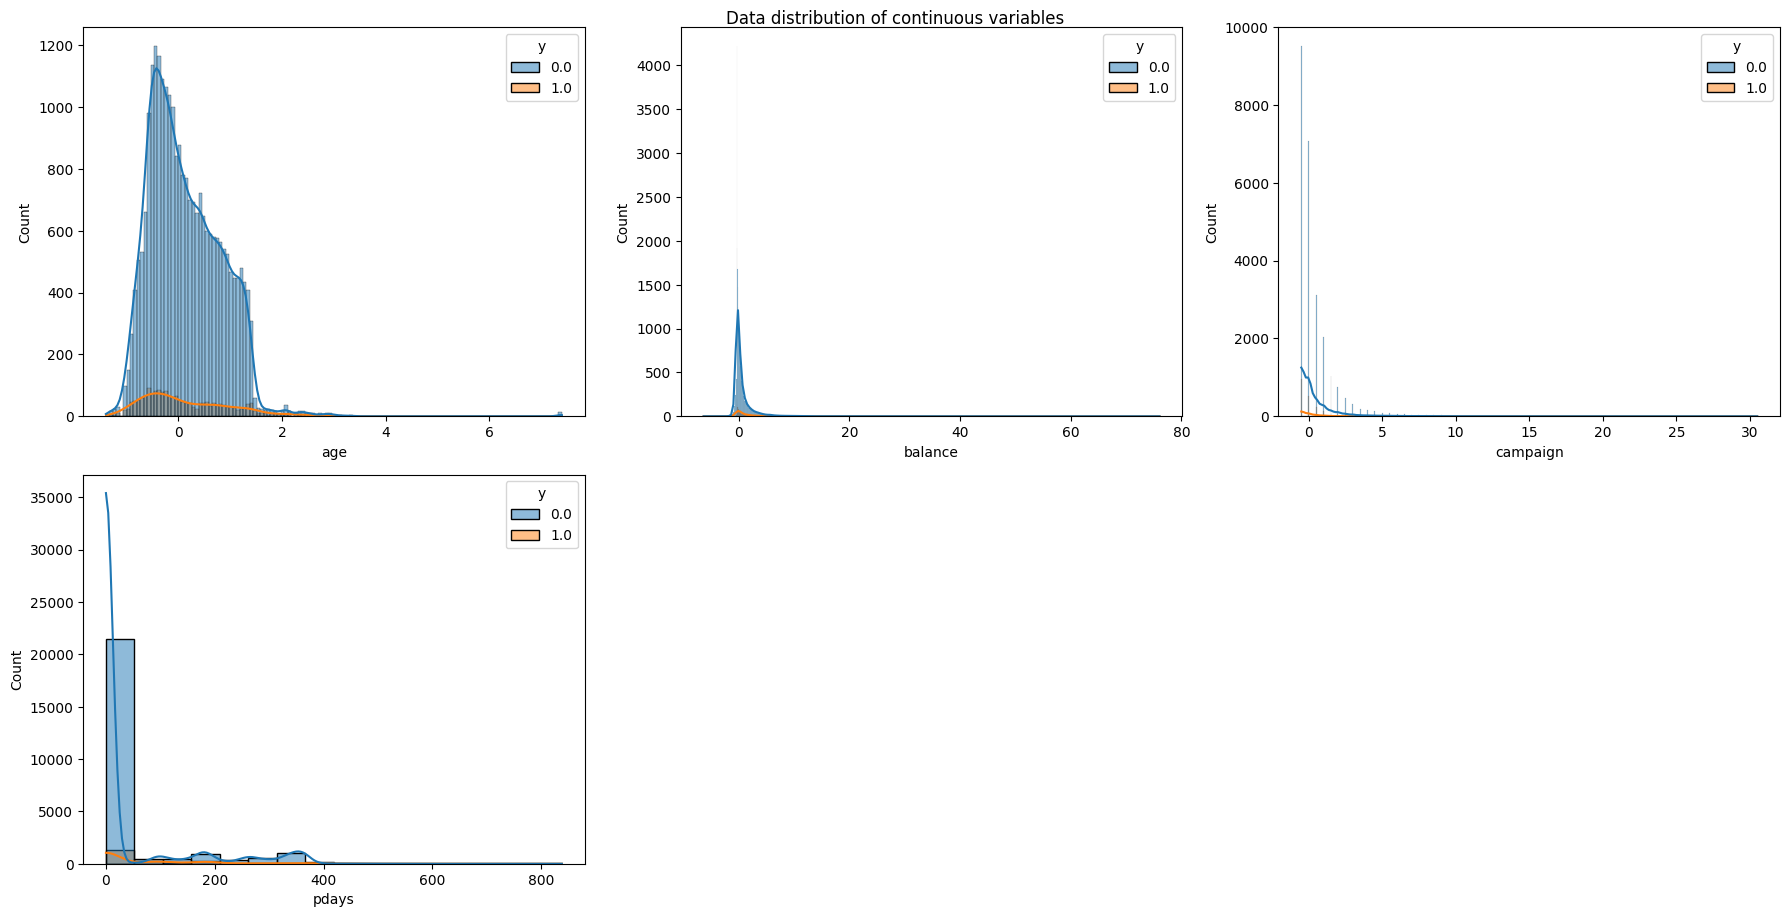

In [40]:
plt.figure(figsize=(18, 18))
for i, col in enumerate(numeric_features):
    ax = plt.subplot(4,3, i+1)
    sns.histplot(data=df_train, x=col, ax=ax,color='blue',kde=True,hue='y')
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()

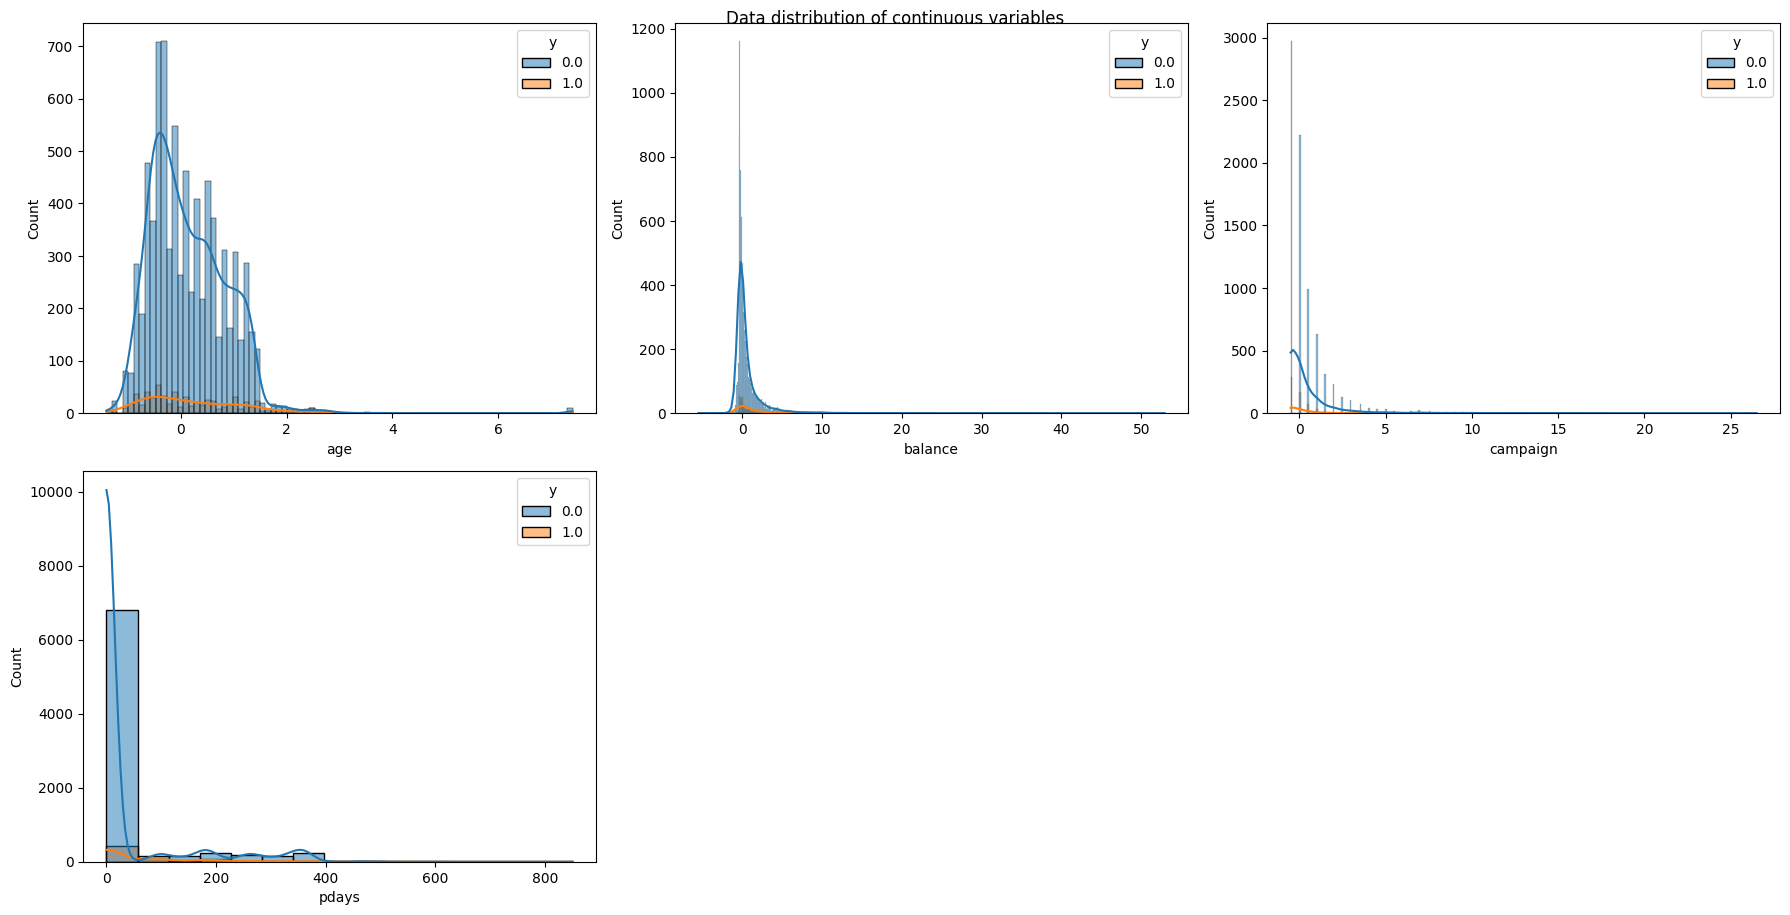

In [41]:
plt.figure(figsize=(18, 18))
for i, col in enumerate(numeric_features):
    ax = plt.subplot(4,3, i+1)
    sns.histplot(data=df_test, x=col, ax=ax,color='blue',kde=True,hue='y')
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()

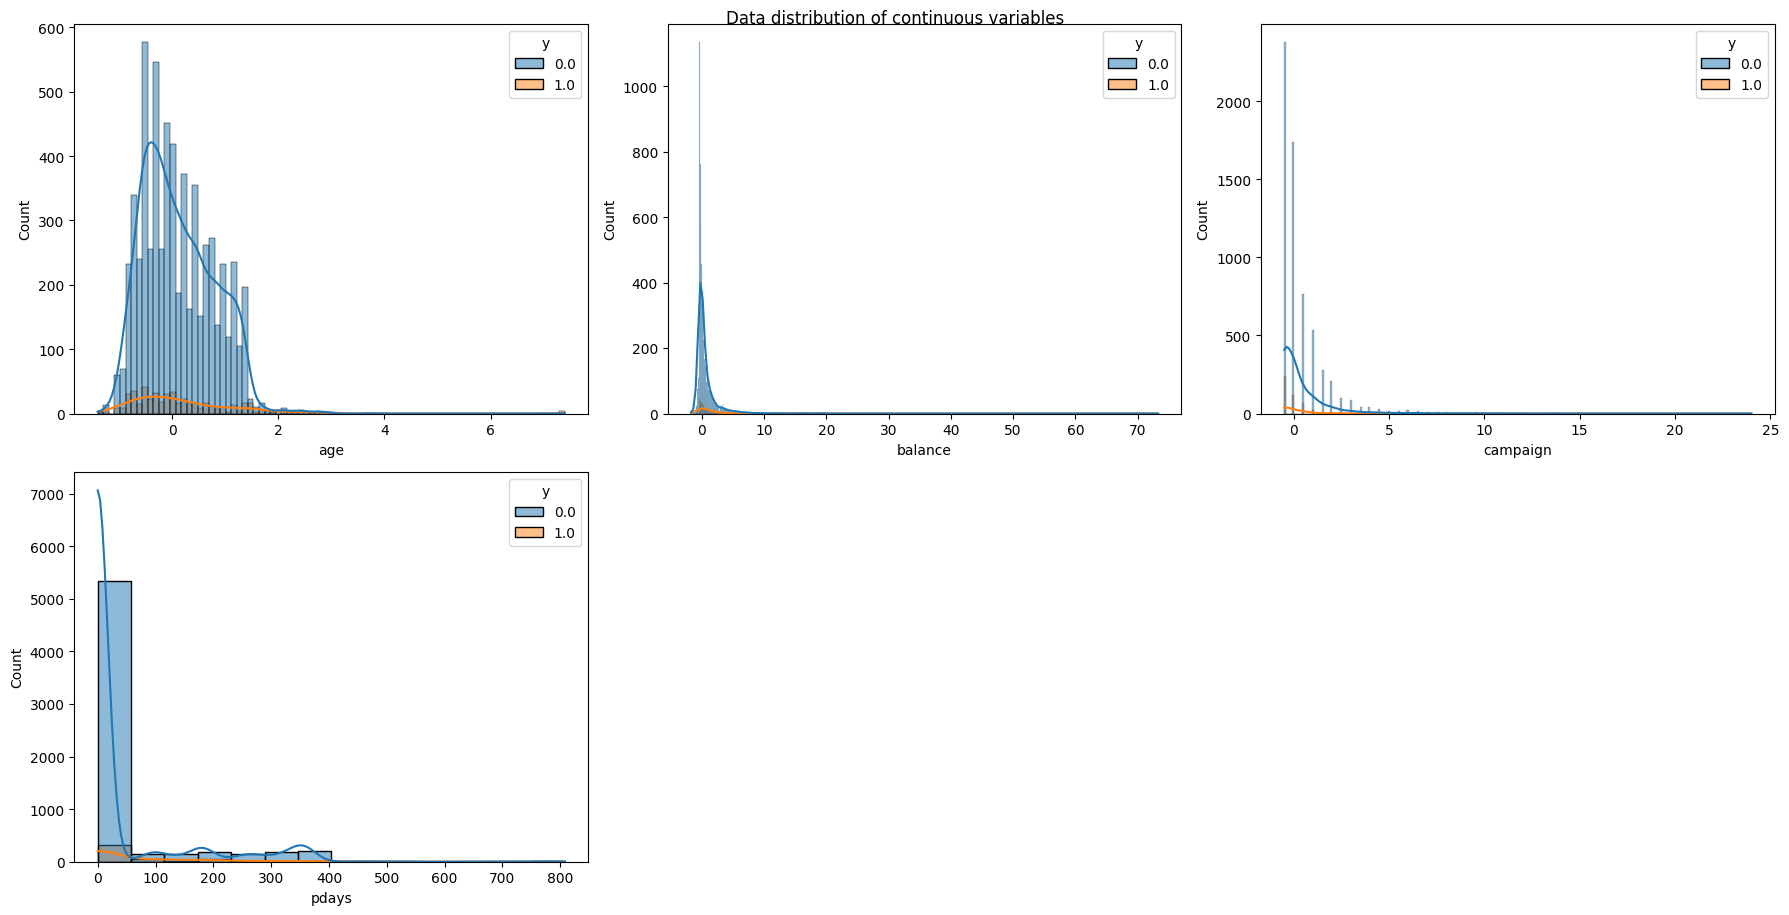

In [42]:
plt.figure(figsize=(18, 18))
for i, col in enumerate(numeric_features):
    ax = plt.subplot(4,3, i+1)
    sns.histplot(data=df_val, x=col, ax=ax,color='blue',kde=True,hue='y')
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()

## 6. Feature selection <a class="anchor" id="sec6"></a>

Le variabili più importanti sono:
1. balance
2. age
3. month
4. campaign
5. pdays
6. education
7. housing
8. job (management)
9. loan
10. previous
11. pdays_cat
12. default

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators=100)
rf.fit(df_val.drop(['y'],axis=1), df_val['y'])

RandomForestClassifier()

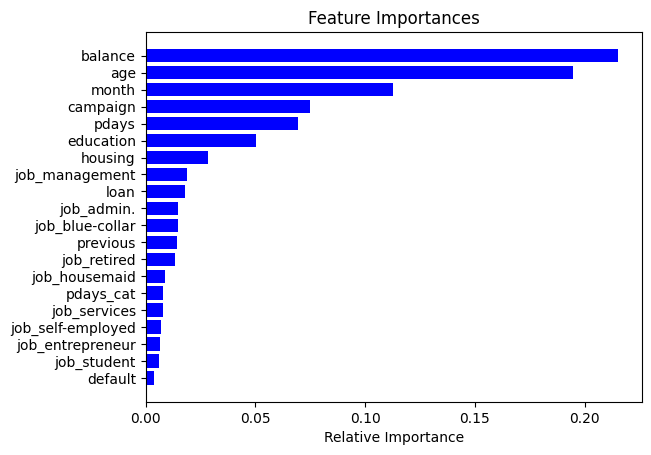

In [44]:
features = rf.feature_names_in_[:20]
importances = rf.feature_importances_[:20]
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 7. Undersampling <a class="anchor" id="sec7"></a>

In [45]:
df_train.y.value_counts()

y
0.0    25402
1.0     1974
Name: count, dtype: int64

In [46]:
df_train.y.value_counts(normalize=True)

y
0.0    0.927893
1.0    0.072107
Name: proportion, dtype: float64

In [47]:
no_select_idx = df_train[df_train.y==0].sample(frac=0.85, random_state=1).index.to_list()
no_select_idx[:5]

[40121, 26635, 28269, 14856, 19924]

In [48]:
df_train2 = df_train[~(df_train.index.isin(no_select_idx))]

In [49]:
df_train2.y.value_counts(normalize=True)

y
0.0    0.658714
1.0    0.341286
Name: proportion, dtype: float64

## Save preprocessed data

In [50]:
df_train2['type_set'] = 'train'
df_test['type_set'] = 'test'
df_val['type_set'] = 'val'

/tmp/ipykernel_19841/1901584586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['type_set'] = 'train'
/tmp/ipykernel_19841/1901584586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['type_set'] = 'test'
/tmp/ipykernel_19841/1901584586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [51]:
final_df = pd.concat([df_train2,df_test,df_val], ignore_index=True)

In [52]:
final_df.to_parquet('../data/processed/bank_data_prepro.parquet')